In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

from PyEMD import EMD
from scipy.signal import hilbert

from LSTM_model import LSTM   # your NumPy LSTM implementation


In [2]:
# 1) Load & scale
df = pd.read_csv('../../data/dataS.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)
X_raw = df[['volatility']].values    # shape (T,1)
y_raw = df[['volatility_forcast']].values  # shape (T,1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw).flatten()  # make it (T,) for easier indexing


In [3]:
# 2) Compute EMD‐based window sizes τₜ
max_W = 20
emd     = EMD()

imfs    = emd.emd(X_scaled.flatten())    # must pass a 1-D array
all_amp = [ np.abs(hilbert(imf)) for imf in imfs ]
all_pow = [ amp**2 for amp in all_amp ]
energies = [ p.mean() for p in all_pow ]

inst_power_norm = np.zeros_like(X_scaled.flatten(), dtype=float)
for p, E in zip(all_pow, energies):
    inst_power_norm += (p / E)

tau_emd = np.clip(np.round(inst_power_norm).astype(int), 1, max_W)
print("first 20 EMD windows:", tau_emd[:20])


first 20 EMD windows: [20 16 16 15 12 11 11 10 10  9  9  9 10 11 10  9 11 11  9  9]


In [4]:
# 3) Build dynamic sequences + mask
def create_dynamic_sequences_with_mask(X, y, tau, max_len):
    Xs, masks, ys = [], [], []
    T, D = X.shape
    for t in range(T):
        w = tau[t]
        if t < w:                   # not enough history yet
            continue

        window = X[t-w : t]         # shape (w, D)
        m      = np.ones((w,1))     # mask=1 for real data

        if w < max_len:
            pad_X = np.zeros((max_len - w, D))
            pad_m = np.zeros((max_len - w, 1))
            window = np.vstack([pad_X, window])
            m      = np.vstack([pad_m,    m     ])

        Xs.append(window)           # → (max_len, D)
        masks.append(m)             # → (max_len, 1)
        ys.append(y[t])             # scalar target
    return np.stack(Xs), np.stack(masks), np.array(ys)

X_dyn, M_dyn, y_dyn = create_dynamic_sequences_with_mask(
    X_scaled,    # (T,1)
    y_scaled,    # (T,)
    tau_emd,     # (T,)
    max_W        # scalar
)
print("X_dyn:", X_dyn.shape, "M_dyn:", M_dyn.shape, "y_dyn:", y_dyn.shape)
# X_dyn = (N, max_W, D), M_dyn = (N, max_W, 1), y_dyn = (N,)


X_dyn: (5360, 20, 1) M_dyn: (5360, 20, 1) y_dyn: (5360,)


In [5]:
# 4) Concatenate mask as extra feature
X_with_mask = np.concatenate([X_dyn, M_dyn], axis=2)
# now shape = (N, max_W, D+1)


In [6]:
# 5) Train/test split (in original time order)
X_train, X_test, y_train, y_test = train_test_split(
    X_with_mask, y_dyn,
    test_size=0.2, shuffle=False
)


In [7]:
# 6) Broadcast each scalar target into a seq‐length long vector
def build_y_seqs(y_flat, seq_length):
    N = len(y_flat)
    Y = np.zeros((N, seq_length, 1))
    for i, val in enumerate(y_flat):
        Y[i, :, 0] = val
    return Y

Y_train = build_y_seqs(y_train, max_W)
Y_test  = build_y_seqs(y_test,  max_W)


In [8]:
# 7) Fit your LSTM
model = LSTM(
    input_dim = X_train.shape[2],  # D+1
    hidden_dim= 64,
    output_dim= 1,
    lr        = 1e-3
)

model.train(
    X_train, Y_train,
    epochs     = 100,
    batch_size = 32,
    val_data   = (X_test, Y_test)
)



Epoch 1/100 — train MSE: 0.0063 — val MSE: 0.0049
Epoch 2/100 — train MSE: 0.0052 — val MSE: 0.0045
Epoch 3/100 — train MSE: 0.0050 — val MSE: 0.0045
Epoch 4/100 — train MSE: 0.0049 — val MSE: 0.0049
Epoch 5/100 — train MSE: 0.0049 — val MSE: 0.0047
Epoch 6/100 — train MSE: 0.0049 — val MSE: 0.0048
Epoch 7/100 — train MSE: 0.0049 — val MSE: 0.0047
Epoch 8/100 — train MSE: 0.0049 — val MSE: 0.0045
Epoch 9/100 — train MSE: 0.0049 — val MSE: 0.0048
Epoch 10/100 — train MSE: 0.0049 — val MSE: 0.0045
Epoch 11/100 — train MSE: 0.0049 — val MSE: 0.0046
Epoch 12/100 — train MSE: 0.0048 — val MSE: 0.0048
Epoch 13/100 — train MSE: 0.0048 — val MSE: 0.0052
Epoch 14/100 — train MSE: 0.0048 — val MSE: 0.0044
Epoch 15/100 — train MSE: 0.0048 — val MSE: 0.0045
Epoch 16/100 — train MSE: 0.0049 — val MSE: 0.0049
Epoch 17/100 — train MSE: 0.0048 — val MSE: 0.0048
Epoch 18/100 — train MSE: 0.0048 — val MSE: 0.0045
Epoch 19/100 — train MSE: 0.0048 — val MSE: 0.0047
Epoch 20/100 — train MSE: 0.0049 — val M

In [9]:
# 8) Predict & evaluate
preds_seq = model.predict(X_test)    # (N_test, max_W, 1)
preds_last = preds_seq[:, -1, 0]     # take last step
y_last     = y_test                  # shape (N_test,)

preds_inv = scaler_y.inverse_transform(preds_last.reshape(-1,1)).flatten()
y_inv     = scaler_y.inverse_transform(y_last .reshape(-1,1)).flatten()

mse  = mean_squared_error(y_inv, preds_inv)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_inv, preds_inv)
mape = mean_absolute_percentage_error(y_inv, preds_inv)
r2   = r2_score(y_inv, preds_inv)

print(f"\nTest MSE={mse:.6f}  RMSE={rmse:.6f}  MAE={mae:.6f}")
print(f"     MAPE={100*mape:.2f}%  R²={r2:.4f}")



Test MSE=0.003625  RMSE=0.060211  MAE=0.040159
     MAPE=55.46%  R²=0.3431


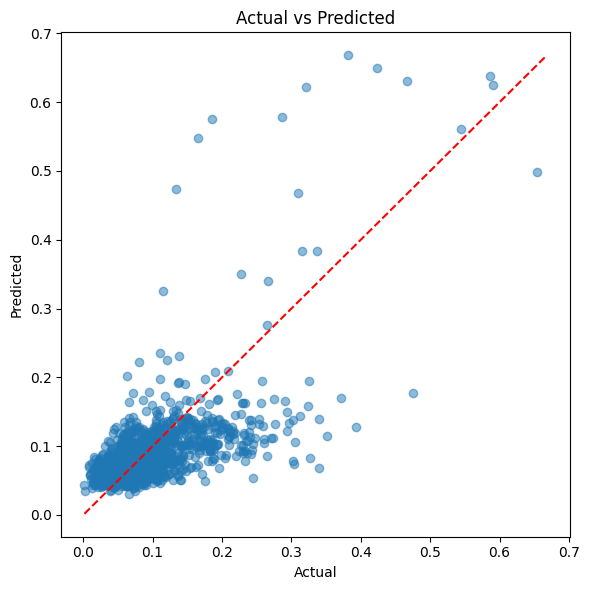

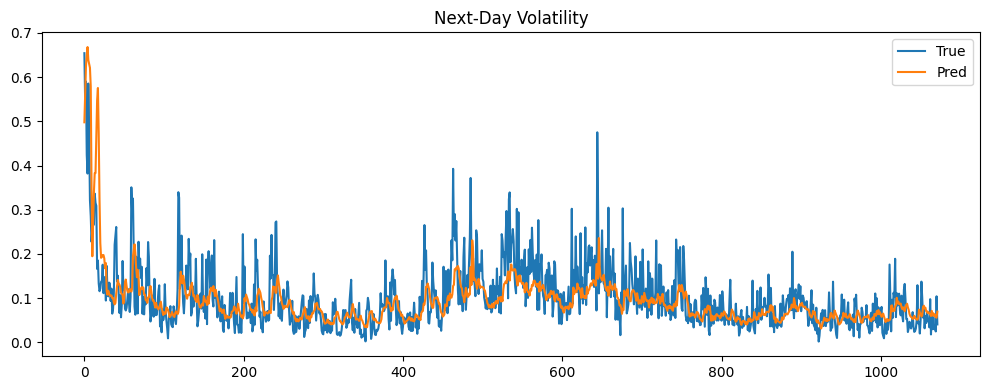

In [10]:
# 9) Quick plots
plt.figure(figsize=(6,6))
plt.scatter(y_inv, preds_inv, alpha=0.5)
lims = [min(y_inv.min(), preds_inv.min()),
        max(y_inv.max(), preds_inv.max())]
plt.plot(lims, lims, 'r--'); plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Actual vs Predicted"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(y_inv,    label='True')
plt.plot(preds_inv, label='Pred')
plt.legend(); plt.title("Next‐Day Volatility"); plt.tight_layout(); plt.show()
